In [2]:
from lightglue import LightGlue, SuperPoint, viz2d, DISK, SIFT, ALIKED, DoGHardNet
from lightglue.utils import load_image, rbd, match_pair
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import torch
import torchvision.transforms.functional as TF
import os

general_folder_path = '/home/oussama/Documents/EPFL/PDS_LUTS/'

# Function to warp perspective with padding
def warpPerspectivePadded(src, dst, transf):
    src_h, src_w = src.shape[:2]
    lin_homg_pts = np.array([[0, src_w, src_w, 0], [0, 0, src_h, src_h], [1, 1, 1, 1]])

    trans_lin_homg_pts = transf.dot(lin_homg_pts)
    trans_lin_homg_pts /= trans_lin_homg_pts[2, :]

    minX = np.min(trans_lin_homg_pts[0, :])
    minY = np.min(trans_lin_homg_pts[1, :])
    maxX = np.max(trans_lin_homg_pts[0, :])
    maxY = np.max(trans_lin_homg_pts[1, :])

    dst_sz = list(dst.shape)
    pad_sz = dst_sz.copy()
    pad_sz[0] = np.round(np.maximum(dst_sz[0], maxY) - np.minimum(0, minY)).astype(int)
    pad_sz[1] = np.round(np.maximum(dst_sz[1], maxX) - np.minimum(0, minX)).astype(int)
    dst_pad = np.zeros(pad_sz, dtype=np.uint8)

    anchorX, anchorY = 0, 0
    transl_transf = np.eye(3, 3)
    if minX < 0:
        anchorX = np.round(-minX).astype(int)
        transl_transf[0, 2] += anchorX
    if minY < 0:
        anchorY = np.round(-minY).astype(int)
        transl_transf[1, 2] += anchorY
    new_transf = transl_transf.dot(transf)
    new_transf /= new_transf[2, 2]

    dst_pad[anchorY:anchorY + dst_sz[0], anchorX:anchorX + dst_sz[1]] = dst
    warped = cv.warpPerspective(src, new_transf, (pad_sz[1], pad_sz[0]))

    return dst_pad, warped, anchorX, anchorY

# Empty cache from gpu
torch.cuda.empty_cache()


/home/oussama/Documents/EPFL/PDS_LUTS/images/0000.jpg
[ 28 395]
[[-1.1539459e-03  2.9897125e+01]
 [ 1.9245963e+03  4.5755005e-01]
 [ 1.9259943e+03  1.0834697e+03]
 [ 2.5692825e+00  1.1158396e+03]]
[[ -28.00115395 -365.10287476]
 [1896.59631348 -394.54244995]
 [1897.9942627   688.46972656]
 [ -25.43071747  720.83959961]]
[[ -28.001154 -365.10287 ]
 [1896.5963   -394.54245 ]
 [1897.9943    688.4697  ]
 [ -25.430717  720.8396  ]]
-28 -394 1897 720


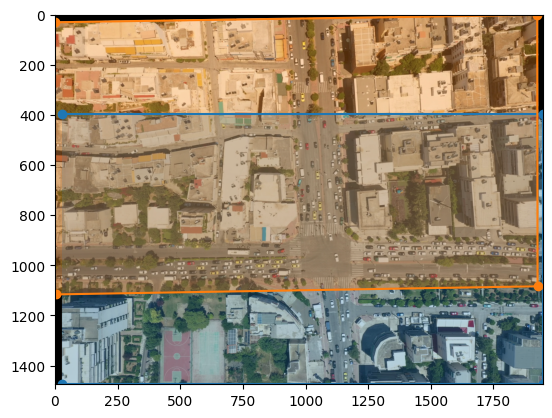

: 

In [4]:
output_path = general_folder_path + 'panorama.jpg'

torch.cuda.empty_cache()

def warpPerspectivePadded(src, dst, transf):
    # Get source image dimensions
    src_h, src_w = src.shape[:2]
    
    # Define the corners of the source image in homogeneous coordinates
    corners = np.array([[0, 0, 1],
                        [src_w, 0, 1],
                        [src_w, src_h, 1],
                        [0, src_h, 1]]).T

    # Transform the corners to find the bounding box in the transformed space
    transformed_corners = transf.dot(corners)
    transformed_corners /= transformed_corners[2, :]  # Normalize (x, y) coordinates

    # Calculate the min and max x and y values for the transformed corners
    minX, minY = np.min(transformed_corners[0]), np.min(transformed_corners[1])
    maxX, maxY = np.max(transformed_corners[0]), np.max(transformed_corners[1])

    # Destination image dimensions
    dst_h, dst_w = dst.shape[:2]

    # Calculate the necessary padded output dimensions based on the bounding box
    pad_h = int(np.round(np.maximum(dst_h, maxY) - np.minimum(0, minY)))
    pad_w = int(np.round(np.maximum(dst_w, maxX) - np.minimum(0, minX)))

    # Initialize a padded output image
    dst_pad = np.zeros((pad_h, pad_w, 3), dtype=np.uint8)

    # Calculate translation offsets to position the transformed image within the bounding box
    anchorX, anchorY = 0, 0
    transl_transf = np.eye(3)
    if minX < 0:
        anchorX = int(np.round(-minX))
        transl_transf[0, 2] = anchorX
    if minY < 0:
        anchorY = int(np.round(-minY))
        transl_transf[1, 2] = anchorY

    # Update transformation matrix to account for translation adjustment
    new_transf = transl_transf.dot(transf)
    new_transf /= new_transf[2, 2]  # Normalize the homography

    # Place the destination image in the padded canvas
    dst_pad[anchorY:anchorY + dst_h, anchorX:anchorX + dst_w] = dst

    # Warp the source image onto the padded canvas with the adjusted transformation
    warped = cv.warpPerspective(src, new_transf, (pad_w, pad_h))

    return dst_pad, warped, anchorX, anchorY

# Function to compute similarity score based on keypoint matching
def compute_similarity_score(image1, image2, extractor, matcher):
    feats0 = extractor.extract(image1)
    feats1 = extractor.extract(image2)
    feats0, feats1, matches01 = match_pair(extractor, matcher, image1, image2)
    matches = matches01['matches']
    points0 = feats0['keypoints'][matches[..., 0]]
    points1 = feats1['keypoints'][matches[..., 1]]
    return points0.shape[0]

# Function to rotate image
def rotate_image(image: torch.Tensor, angle: float) -> torch.Tensor:
    rotated_image = TF.rotate(image, angle)
    return rotated_image

# Initialize SuperPoint and LightGlue for feature extraction and matching
extractor = DoGHardNet(max_num_keypoints=None).eval().cuda()  # load the extractor
matcher = LightGlue(features='doghardnet').eval().cuda()  # load the matcher

# Load the images
image_path0 = general_folder_path + 'images/0000.jpg'
image_path1 = general_folder_path + 'images/0200.jpg'

print(image_path0)

# Load each image as a torch.Tensor on GPU with shape (3,H,W), normalized in [0,1]
image0 = load_image(image_path0)
image1 = load_image(image_path1)

# Dictionary to store corner coordinates of each image in the final stitched result
image_corners = {image_path0: np.array([[0, 0], [image0.shape[2]-1, 0], 
                                            [image0.shape[2]-1, image0.shape[1]-1], 
                                            [0, image0.shape[1]-1]])}

# Extract local features
feats0 = extractor.extract(image0)  # auto-resize the image, disable with resize=None

# Determine the best rotation angle
rotation_angles = range(0, 360, 45)
best_score = -1
best_angle = 0
best_rotated_image = image1

for angle in rotation_angles:
    rotated_image1 = rotate_image(image1, angle)

    torch.cuda.empty_cache()
    
    score = compute_similarity_score(image0, rotated_image1, extractor, matcher)
    
    if score > best_score:
        best_score = score
        best_angle = angle
        best_rotated_image = rotated_image1
        del rotated_image1
        torch.cuda.empty_cache()

# Convert to OpenCV format for final stitching
imocv0 = cv.imread(image_path0)
imocv1 = TF.to_pil_image(best_rotated_image.cpu()).convert("RGB")
imocv1 = cv.cvtColor(np.array(imocv1), cv.COLOR_RGB2BGR)

# Extract matched keypoints
feats0 = extractor.extract(image0)
feats1 = extractor.extract(best_rotated_image)
feats0, feats1, matches01 = match_pair(extractor, matcher, image0, best_rotated_image)
matches = matches01['matches']
points0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()
points1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()

# Compute homography and stitch
if points0.shape[0] >= 4:
    M, _ = cv.findHomography(points1, points0, cv.RANSAC, 5.0)
    dst_padded, warped_image1, anchorX, anchorY = warpPerspectivePadded(imocv1, imocv0, M)

    # Calculate the corners for the new image
    h, w = imocv1.shape[:2]
    new_image_corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype='float32')
    transformed_corners = cv.perspectiveTransform(np.array([new_image_corners]), M)[0]
    transformed_corners += np.array([anchorX, anchorY])
    image_corners[image_path1] = transformed_corners

    # Update the coordinates of previously stitched images
    for img_path, corners in image_corners.items():
        if img_path != image_path1:  # Only update previously stitched images
            image_corners[img_path] += np.array([anchorX, anchorY])
            print(np.array([anchorX, anchorY]))

    # Combine non-overlapping regions
    non_zero_mask = (warped_image1 > 0).astype(np.uint8)
    dst_padded[non_zero_mask == 1] = warped_image1[non_zero_mask == 1]

    last_key = list(image_corners.keys())[-1]
    print(image_corners[last_key])
    warped_image_corners = image_corners[last_key]-np.array([anchorX, anchorY])
    print(warped_image_corners)
    x_coords, y_coords = warped_image_corners[:, 0], warped_image_corners[:, 1]

    # Define source corners as a numpy array of four points
    corners = np.array([[x_coords[0], y_coords[0]],
                        [x_coords[1], y_coords[1]],
                        [x_coords[2], y_coords[2]],
                        [x_coords[3], y_coords[3]]], dtype=np.float32)
    
    print(corners)

    x_min, y_min = np.min(corners, axis=0).astype(int)
    x_max, y_max = np.max(corners, axis=0).astype(int)

    print(x_min, y_min, x_max, y_max)

    # Crop the region of interest
    warped_image2 = warped_image1[y_min:y_max, x_min:x_max]
    # cv.imwrite(general_folder_path + 'warped_image1.jpg', warped_image2)

    # Update the current panorama and base image path
    current_panorama = torch.from_numpy(dst_padded).permute(2, 0, 1).float().cuda() / 255.0

    # Save the intermediate panorama
    cv.imwrite(general_folder_path + 'panorama.jpg', dst_padded)
else:
    pass

# Create a mask to identify non-zero regions in warped_image1
non_zero_mask = (warped_image1 > 0).astype(np.uint8)

# Add the warped_image1 to dst_padded only where dst_padded has zeros (non-overlapping regions)
dst_padded[non_zero_mask == 1] = warped_image1[non_zero_mask == 1]

# Convert current_panorama to numpy array for display
current_panorama_np = current_panorama.cpu().permute(1, 2, 0).numpy() * 255  # Convert from (C, H, W) to (H, W, C) and scale to [0, 255]
current_panorama_np = current_panorama_np.astype(np.uint8)  # Ensure it's in uint8 format

plt.imshow(cv.cvtColor(current_panorama_np, cv.COLOR_BGR2RGB))
plt.axis('on')

# Plot the corners of each image on the stitched panorama
for img_path, corners in image_corners.items():
    # Corners in (x, y) format
    x_coords, y_coords = corners[:, 0], corners[:, 1]
    plt.plot(x_coords, y_coords, 'o-', label=os.path.basename(img_path))  # Plot as line with markers
    plt.fill(x_coords, y_coords, alpha=0.3)  # Light fill to indicate image area
    
plt.show()


In [56]:
print(image_corners)

{'/home/oussama/Documents/EPFL/PDS_LUTS/warped_image1.jpg': array([[   0,    0],
       [3942,    0],
       [3942, 2896],
       [   0, 2896]]), '/home/oussama/Documents/EPFL/PDS_LUTS/images/4200.jpg': array([[ 169.5129, 1694.2466],
       [3651.798 ,  778.994 ],
       [4167.318 , 3152.8208],
       [ 542.4781, 4102.9565]], dtype=float32)}


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the images
current_panorama = cv.imread(general_folder_path + 'panorama.jpg')
new_image = cv.imread(general_folder_path + 'panorama1.jpg')

# Define the bounding box coordinates of the common region in both images
xmin1, ymin1, xmax1, ymax1 = 0, 0, 1937, 1122
anchorX1, anchorY1 = 30, 403
xmin2, ymin2, xmax2, ymax2 = 0, 0, 1947, 1114
anchorX2, anchorY2 = 42, 502

# Calculate the translation needed to align the common regions
translation_x = xmin1 - xmin2
translation_y = ymin1 - ymin2

# Create a 3x3 translation matrix
translation_matrix = np.float32([
    [1, 0, 30],
    [0, 1, 403],
    [0, 0, 1]
])

# Apply the translation to the second image using warpAffine
# Use the dimensions of the first image for the output size
dst_padded, warped_image, anchorX, anchorY = warpPerspectivePadded(new_image, current_panorama, translation_matrix)

plt.imshow(cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.imshow(cv.cvtColor(warped_image1, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Create a mask to identify non-zero regions in warped_image1
non_zero_mask = (warped_image > 0).astype(np.uint8)

# Add the warped_image1 to dst_padded only where dst_padded has zeros (non-overlapping regions)
dst_padded[non_zero_mask == 1] = warped_image[non_zero_mask == 1]

cv.imwrite(general_folder_path + 'aligned_image.jpg', dst_padded)

plt.imshow(cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
import os
import torch
import cv2 as cv
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Initialize extractor and matcher
extractor = DoGHardNet(max_num_keypoints=None).eval().cuda()  # load the extractor
matcher = LightGlue(features='doghardnet').eval().cuda()  # load the matcher

# Load the images
image_path0 = os.path.join(general_folder_path, 'images/frame_000200.jpg')
image_path1 = os.path.join(general_folder_path, 'images/frame_000400.jpg')

# Load each image as a torch.Tensor on GPU with shape (3,H,W), normalized in [0,1]
image0 = load_image(image_path0)
image1 = load_image(image_path1)

# Extract local features
feats0 = extractor.extract(image0)  # auto-resize the image, disable with resize=None
feats1 = extractor.extract(image1)
feats0, feats1, matches01 = match_pair(extractor, matcher, image0, image1)

# Get matched keypoints
matches = matches01['matches']  # indices with shape (K,2)
kps0 = feats0['keypoints']
kps1 = feats1['keypoints']
points0 = kps0[matches[..., 0]]  # coordinates in image #0, shape (K,2)
points1 = kps1[matches[..., 1]]  # coordinates in image #1, shape (K,2)

# Load images with OpenCV for further processing
imocv0 = cv.imread(image_path0)
imocv1 = cv.imread(image_path1)

# Compute the homography
M, _ = cv.findHomography(points1.cpu().numpy(), points0.cpu().numpy(), cv.RANSAC, 5.0)
print("Homography Matrix:\n", M)

# Define corners of the second image in its original coordinates
h, w = imocv1.shape[:2]
corners = np.array([
    [0, 0],      # Top-left corner
    [w, 0],      # Top-right corner
    [w, h],      # Bottom-right corner
    [0, h]       # Bottom-left corner
], dtype=np.float32)

# Apply the homography matrix to get corners in the panorama frame
corners_transformed = cv.perspectiveTransform(corners[None, :, :], M)[0]
print("Transformed Corners (pre-padding):", corners_transformed)

# Apply warpPerspectivePadded
dst_padded, warped_image1, anchorX, anchorY = warpPerspectivePadded(imocv1, imocv0, M)

# Adjust transformed corners with padding offsets
corners_transformed_padded = corners_transformed + np.array([anchorX, anchorY])

print("Transformed Corners in warped_image1 (post-padding):")
for i, (x, y) in enumerate(corners_transformed_padded):
    print(f"Corner {i+1}: (x={x:.2f}, y={y:.2f})")

# Draw the transformed corners on warped_image1
for x, y in corners_transformed_padded:
    cv.circle(warped_image1, (int(x), int(y)), radius=20, color=(0, 0, 255), thickness=-1)

# Show the padded and warped image with corners marked
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(warped_image1, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Save the result
output_path = 'warped_image_with_padded_corners.jpg'
cv.imwrite(output_path, warped_image1)
print(f"Warped image with padded corners saved as '{output_path}'")


In [ ]:
import os
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Initialize extractor and matcher
extractor = DoGHardNet(max_num_keypoints=None).eval().cuda()
matcher = LightGlue(features='doghardnet').eval().cuda()

# Paths for images
image_path0 = os.path.join(general_folder_path, 'images/frame_000200.jpg')
image_path1 = os.path.join(general_folder_path, 'images/frame_000400.jpg')
image_path2 = os.path.join(general_folder_path, 'images/frame_000600.jpg')

# Load each image with OpenCV for processing
imocv0 = cv.imread(image_path0)
imocv1 = cv.imread(image_path1)
imocv2 = cv.imread(image_path2)

# Initialize the coordinates for the corners of each image in its own frame
def get_initial_corners(img):
    h, w = img.shape[:2]
    return np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)

# Initialize the stitched image and base image corners
stitched_image = imocv0
corners_img0 = get_initial_corners(imocv0)

# Utility function to apply padding offsets to previous corners
def apply_padding_offsets(corners, anchorX, anchorY):
    return corners + np.array([anchorX, anchorY])

# Stitch image 1 with the base image (image 0)
# Feature extraction and matching for image 0 and image 1
image0 = load_image(image_path0)
image1 = load_image(image_path1)
feats0 = extractor.extract(image0)
feats1 = extractor.extract(image1)
feats0, feats1, matches01 = match_pair(extractor, matcher, image0, image1)
points0 = feats0['keypoints'][matches01['matches'][..., 0]].cpu().numpy()
points1 = feats1['keypoints'][matches01['matches'][..., 1]].cpu().numpy()
M_01, _ = cv.findHomography(points1, points0, cv.RANSAC, 5.0)

# Apply padding and warp image 1
dst_padded, warped_image1, anchorX1, anchorY1 = warpPerspectivePadded(imocv1, imocv0, M_01)
stitched_image = dst_padded

# Transform corners for image 1 after padding
corners_img1 = cv.perspectiveTransform(get_initial_corners(imocv1)[None, :, :], M_01)[0]
corners_img1_padded = apply_padding_offsets(corners_img1, anchorX1, anchorY1)

# Stitch image 2 with the stitched result of images 0 and 1
# Feature extraction and matching for stitched image and image 2
image2 = load_image(image_path2)
feats2 = extractor.extract(image2)
feats0, feats2, matches02 = match_pair(extractor, matcher, image0, image2)
points0 = feats0['keypoints'][matches02['matches'][..., 0]].cpu().numpy()
points2 = feats2['keypoints'][matches02['matches'][..., 1]].cpu().numpy()
M_02, _ = cv.findHomography(points2, points0, cv.RANSAC, 5.0)

# Apply padding and warp image 2
dst_padded, warped_image2, anchorX2, anchorY2 = warpPerspectivePadded(imocv2, stitched_image, M_02)
stitched_image = dst_padded

# Transform corners for image 2 after padding
corners_img2 = cv.perspectiveTransform(get_initial_corners(imocv2)[None, :, :], M_02)[0]
corners_img2_padded = apply_padding_offsets(corners_img2, anchorX2, anchorY2)

# Update corners of all images with respective padding offsets
corners_img0 = apply_padding_offsets(corners_img0, anchorX1, anchorY1)

# Display corners on the final stitched image
for corner in corners_img0:
    cv.circle(stitched_image, (int(corner[0]), int(corner[1])), radius=10, color=(255, 0, 0), thickness=-1)  # Blue for image 0
for corner in corners_img1_padded:
    cv.circle(stitched_image, (int(corner[0]), int(corner[1])), radius=10, color=(0, 255, 0), thickness=-1)  # Green for image 1
for corner in corners_img2_padded:
    cv.circle(stitched_image, (int(corner[0]), int(corner[1])), radius=10, color=(0, 0, 255), thickness=-1)  # Red for image 2

# Show the final stitched image with corners
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Save the result
output_path = 'stitched_image_with_three_images_consecutively.jpg'
cv.imwrite(output_path, stitched_image)
print(f"Stitched image with corners for three images saved as '{output_path}'")


In [ ]:
import os
from tqdm import tqdm
from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image, rbd
import cv2 as cv
import numpy as np

# Initialize SuperPoint and LightGlue for feature extraction and matching
extractor = SuperPoint(max_num_keypoints=2048).eval()
matcher = LightGlue(features='superpoint').eval()

# Folder path containing the images to be stitched
image_folder = '/Users/user/Documents/EPFL/MA3/PDS_LUTS/LightGlue/images'
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

# Save the first image as the initial panorama
cv.imwrite('panorama_temp.jpg', cv.imread(image_files[0]))  # Save initial image

# Function to warp perspective with padding
def warpPerspectivePadded(src, dst, transf):
    src_h, src_w = src.shape[:2]
    lin_homg_pts = np.array([[0, src_w, src_w, 0], [0, 0, src_h, src_h], [1, 1, 1, 1]])

    trans_lin_homg_pts = transf.dot(lin_homg_pts)
    trans_lin_homg_pts /= trans_lin_homg_pts[2, :]

    minX = np.min(trans_lin_homg_pts[0, :])
    minY = np.min(trans_lin_homg_pts[1, :])
    maxX = np.max(trans_lin_homg_pts[0, :])
    maxY = np.max(trans_lin_homg_pts[1, :])

    dst_sz = list(dst.shape)
    pad_sz = dst_sz.copy()
    pad_sz[0] = np.round(np.maximum(dst_sz[0], maxY) - np.minimum(0, minY)).astype(int)
    pad_sz[1] = np.round(np.maximum(dst_sz[1], maxX) - np.minimum(0, minX)).astype(int)
    dst_pad = np.zeros(pad_sz, dtype=np.uint8)

    anchorX, anchorY = 0, 0
    transl_transf = np.eye(3, 3)
    if minX < 0:
        anchorX = np.round(-minX).astype(int)
        transl_transf[0, 2] += anchorX
    if minY < 0:
        anchorY = np.round(-minY).astype(int)
        transl_transf[1, 2] += anchorY
    new_transf = transl_transf.dot(transf)
    new_transf /= new_transf[2, 2]

    dst_pad[anchorY:anchorY + dst_sz[0], anchorX:anchorX + dst_sz[1]] = dst
    warped = cv.warpPerspective(src, new_transf, (pad_sz[1], pad_sz[0]))

    return dst_pad, warped

# Sequentially stitch each image onto the current panorama
for i in tqdm(range(1, len(image_files)), desc="Stitching images"):
    image_path = image_files[i]

    # Load the current image and the panorama as tensors for feature extraction
    image0 = load_image(image_path)  # New image
    image1 = load_image('panorama_temp.jpg')  # Current panorama

    # Extract local features
    feats0 = extractor.extract(image0)
    feats1 = extractor.extract(image1)

    # Match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]

    # Get matched keypoints
    matches = matches01['matches']
    kps0 = feats0['keypoints']
    kps1 = feats1['keypoints']
    points0 = kps0[matches[..., 0]]
    points1 = kps1[matches[..., 1]]

    # Load images with OpenCV for further processing
    imocv0 = cv.imread(image_path)
    imocv1 = cv.imread('panorama_temp.jpg')

    # Compute the homography
    M, _ = cv.findHomography(points1.numpy(), points0.numpy(), cv.RANSAC, 5.0)

    # Stitch the images using the homography matrix
    dst_padded, warped_image1 = warpPerspectivePadded(imocv1, imocv0, M)

    # Overlay non-overlapping parts of warped_image1 onto dst_padded
    non_zero_mask = (warped_image1 > 0).astype(np.uint8)
    dst_padded[non_zero_mask == 1] = warped_image1[non_zero_mask == 1]

    # Save the updated panorama for the next iteration
    cv.imwrite('panorama_temp.jpg', dst_padded)

# Save the final panorama
final_panorama = cv.imread('panorama_temp.jpg')
cv.imwrite('panorama.jpg', final_panorama)
print("Final panorama saved as 'panorama.jpg'.")


In [8]:
import torch
import cv2 as cv
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Function to rotate image
def rotate_image(image: torch.Tensor, angle: float) -> torch.Tensor:
    rotated_image = TF.rotate(image, angle)
    return rotated_image

# Function to compute similarity score between two images based on keypoint matching
def compute_similarity_score(image1, image2, extractor, matcher):
    # Extract features
    feats0 = extractor.extract(image1)
    feats1 = extractor.extract(image2)

    # Match the features
    feats0, feats1, matches01 = match_pair(extractor, matcher, image1, image2)

    # Get matched keypoints
    matches = matches01['matches']
    points0 = feats0['keypoints'][matches[..., 0]]
    points1 = feats1['keypoints'][matches[..., 1]]

    # Similarity score based on number of matches
    return points0.shape[0]  # Higher score means more matches

# Initialize extractor and matcher
extractor = DoGHardNet(max_num_keypoints=None).eval().cuda()  # Set max_num_keypoints to None
matcher = LightGlue(features='doghardnet').eval().cuda()  # Initialize matcher

# Load images
image_path0 = general_folder_path + 'stitched_panorama.jpg'
image_path1 = general_folder_path + 'images/frame_001400.jpg'
image0 = load_image(image_path0)
image1 = load_image(image_path1)

# Define rotation angles to try
rotation_angles = range(0, 360, 45)  # Test every 45 degrees
best_score = -1
best_angle = 0
best_rotated_image = image1

# Iterate over rotation angles and compute similarity score
for angle in rotation_angles:
    rotated_image1 = rotate_image(image1, angle)
    score = compute_similarity_score(image0, rotated_image1, extractor, matcher)
    
    # Update best score and rotation angle if current score is higher
    if score > best_score:
        best_score = score
        best_angle = angle
        best_rotated_image = rotated_image1

print(f"Best rotation angle: {best_angle} degrees with similarity score: {best_score}")

# Load OpenCV images for final stitching
imocv0 = cv.imread(image_path0)
imocv1 = TF.to_pil_image(best_rotated_image.cpu()).convert("RGB")
imocv1 = cv.cvtColor(np.array(imocv1), cv.COLOR_RGB2BGR)

# Extract matched keypoints in OpenCV format
feats0 = extractor.extract(image0)
feats1 = extractor.extract(best_rotated_image)
feats0, feats1, matches01 = match_pair(extractor, matcher, image0, best_rotated_image)
matches = matches01['matches']
points0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()
points1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()

# Compute homography and stitch images
if points0.shape[0] >= 4:
    M, _ = cv.findHomography(points1, points0, cv.RANSAC, 5.0)
    dst_padded, warped_image1 = warpPerspectivePadded(imocv1, imocv0, M)
    
    # Display stitched result
    plt.figure(figsize=(10, 10))
    plt.imshow(cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    # Combine and save final panorama
    non_zero_mask = (warped_image1 > 0).astype(np.uint8)
    dst_padded[non_zero_mask == 1] = warped_image1[non_zero_mask == 1]
    output_path = general_folder_path + 'stitched_panorama.jpg'
    cv.imwrite(output_path, dst_padded)
    print(f"Stitched panorama saved as '{output_path}'")
else:
    print("Not enough matches to compute homography.")


FileNotFoundError: No image at path /home/oussama/Documents/EPFL/PDS_LUTS/images/frame_001400.jpg.

In [ ]:
import os
import torch
import cv2 as cv
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Function to rotate image
def rotate_image(image: torch.Tensor, angle: float) -> torch.Tensor:
    rotated_image = TF.rotate(image, angle)
    return rotated_image

# Function to compute similarity score between two images based on keypoint matching
def compute_similarity_score(image1, image2, extractor, matcher):
    feats0 = extractor.extract(image1)
    feats1 = extractor.extract(image2)
    feats0, feats1, matches01 = match_pair(extractor, matcher, image1, image2)
    matches = matches01['matches']
    points0 = feats0['keypoints'][matches[..., 0]]
    points1 = feats1['keypoints'][matches[..., 1]]
    return points0.shape[0]

# Initialize extractor and matcher
extractor = DoGHardNet(max_num_keypoints=None).eval().cuda()
matcher = LightGlue(features='doghardnet').eval().cuda()

# Folder paths
image_folder_path = os.path.join(general_folder_path, 'images')
output_path = os.path.join(general_folder_path, 'stitched_panorama.jpg')

# Sort images by filename for sequential processing
image_files = sorted([os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith('.jpg')])

# Start with the first image as the base panorama
base_image_path = image_files[0]
current_panorama = load_image(base_image_path)

# Loop through the rest of the images with a progress bar
for image_path in tqdm(image_files[1:], desc="Stitching images"):
    image1 = load_image(image_path)
    
    # Find the best rotation angle for the current image
    rotation_angles = range(0, 360, 45)
    best_score = -1
    best_angle = 0
    best_rotated_image = image1

    for angle in rotation_angles:
        rotated_image1 = rotate_image(image1, angle)
        score = compute_similarity_score(current_panorama, rotated_image1, extractor, matcher)
        
        if score > best_score:
            best_score = score
            best_angle = angle
            best_rotated_image = rotated_image1

    # print(f"Best rotation angle for {os.path.basename(image_path)}: {best_angle} degrees with similarity score: {best_score}")

    # Convert images to OpenCV format for final stitching
    imocv0 = cv.imread(base_image_path)
    imocv1 = TF.to_pil_image(best_rotated_image.cpu()).convert("RGB")
    imocv1 = cv.cvtColor(np.array(imocv1), cv.COLOR_RGB2BGR)

    # Extract matched keypoints
    feats0 = extractor.extract(current_panorama)
    feats1 = extractor.extract(best_rotated_image)
    feats0, feats1, matches01 = match_pair(extractor, matcher, current_panorama, best_rotated_image)
    matches = matches01['matches']
    points0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()
    points1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()

    # Compute homography and stitch
    if points0.shape[0] >= 4:
        M, _ = cv.findHomography(points1, points0, cv.RANSAC, 5.0)
        dst_padded, warped_image1 = warpPerspectivePadded(imocv1, imocv0, M)

        # Combine non-overlapping regions
        non_zero_mask = (warped_image1 > 0).astype(np.uint8)
        dst_padded[non_zero_mask == 1] = warped_image1[non_zero_mask == 1]

        # Update the current panorama with the new stitched result
        current_panorama = torch.from_numpy(dst_padded).permute(2, 0, 1).float().cuda() / 255.0
        base_image_path = output_path  # Update base image for the next iteration

        # Save the intermediate panorama
        cv.imwrite(output_path, dst_padded)
    else:
        print(f"Not enough matches to compute homography for {os.path.basename(image_path)}")

torch.cuda.empty_cache()

# Display the final stitched panorama
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print(f"Final stitched panorama saved as '{output_path}'")


Stitching images:  33%|███▎      | 5/15 [00:32<00:58,  5.88s/it]

Not enough matches to compute homography for 1600.jpg


Stitching images:  40%|████      | 6/15 [00:37<00:50,  5.58s/it]

Not enough matches to compute homography for 1800.jpg


Stitching images:  47%|████▋     | 7/15 [00:42<00:42,  5.30s/it]

Not enough matches to compute homography for 200.jpg


Stitching images:  53%|█████▎    | 8/15 [00:47<00:36,  5.15s/it]

Not enough matches to compute homography for 2000.jpg


Stitching images:  60%|██████    | 9/15 [00:52<00:30,  5.05s/it]

Not enough matches to compute homography for 2200.jpg


Stitching images:  67%|██████▋   | 10/15 [00:57<00:25,  5.03s/it]

Not enough matches to compute homography for 2400.jpg


Stitching images:  73%|███████▎  | 11/15 [01:02<00:20,  5.09s/it]

Not enough matches to compute homography for 2600.jpg


Stitching images:  87%|████████▋ | 13/15 [01:13<00:10,  5.29s/it]

Not enough matches to compute homography for 3000.jpg


Stitching images:  93%|█████████▎| 14/15 [01:18<00:05,  5.27s/it]

Not enough matches to compute homography for 3200.jpg


Stitching images: 100%|██████████| 15/15 [01:24<00:00,  5.61s/it]

Not enough matches to compute homography for 3400.jpg


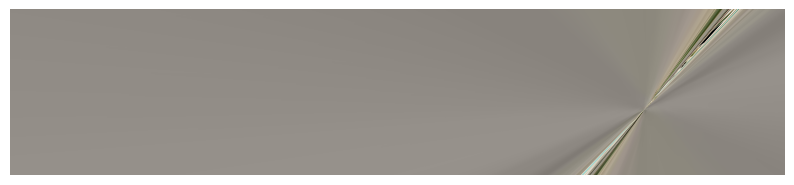

Final stitched panorama saved as '/home/oussama/Documents/EPFL/PDS_LUTS/stitched_panorama.jpg'
Corner coordinates for each image in the stitched panorama:
0.jpg: [[13871.   904.]
 [15791.   904.]
 [15791.  1984.]
 [13871.  1984.]]
1000.jpg: [[1.4132698e+04 9.3923907e+02]
 [1.5554730e+04 9.0712109e+02]
 [1.3188069e+04 2.1411133e-01]
 [1.7186766e+04 2.8329810e+02]]
1200.jpg: [[1.4458444e+04 8.4023029e+02]
 [1.5382679e+04 8.4038641e+02]
 [1.6431627e+04 1.3202465e+03]
 [4.0332031e-01 3.6738086e+03]]
1400.jpg: [[14770.096   1221.5924]
 [14672.708   1296.3691]
 [15269.329    789.4537]
 [14619.64    1348.5563]]
2800.jpg: [[14336.829   1911.1469]
 [13760.48    2567.3755]
 [14225.177   2041.1261]
 [13941.472   2366.639 ]]


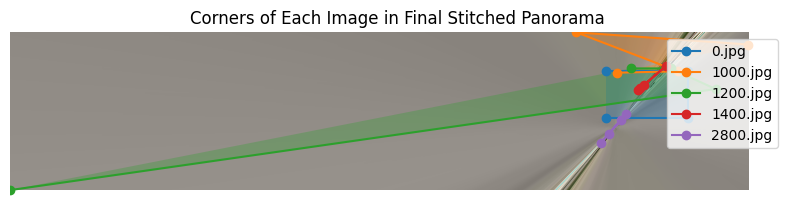

Corner coordinates for each image in the stitched panorama:
0.jpg: [[13871.   904.]
 [15791.   904.]
 [15791.  1984.]
 [13871.  1984.]]
1000.jpg: [[1.4132698e+04 9.3923907e+02]
 [1.5554730e+04 9.0712109e+02]
 [1.3188069e+04 2.1411133e-01]
 [1.7186766e+04 2.8329810e+02]]
1200.jpg: [[1.4458444e+04 8.4023029e+02]
 [1.5382679e+04 8.4038641e+02]
 [1.6431627e+04 1.3202465e+03]
 [4.0332031e-01 3.6738086e+03]]
1400.jpg: [[14770.096   1221.5924]
 [14672.708   1296.3691]
 [15269.329    789.4537]
 [14619.64    1348.5563]]
2800.jpg: [[14336.829   1911.1469]
 [13760.48    2567.3755]
 [14225.177   2041.1261]
 [13941.472   2366.639 ]]


In [2]:
import os
import torch
import cv2 as cv
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm

from lightglue import LightGlue, SuperPoint, viz2d, DISK, SIFT, ALIKED, DoGHardNet
from lightglue.utils import load_image, rbd, match_pair
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import torch
import torchvision.transforms.functional as TF
import os

general_folder_path = '/home/oussama/Documents/EPFL/PDS_LUTS/'

torch.cuda.empty_cache()

# Function to rotate image
def rotate_image(image: torch.Tensor, angle: float) -> torch.Tensor:
    rotated_image = TF.rotate(image, angle)
    return rotated_image

# Function to compute similarity score based on keypoint matching
def compute_similarity_score(image1, image2, extractor, matcher):
    feats0 = extractor.extract(image1)
    feats1 = extractor.extract(image2)
    feats0, feats1, matches01 = match_pair(extractor, matcher, image1, image2)
    matches = matches01['matches']
    points0 = feats0['keypoints'][matches[..., 0]]
    points1 = feats1['keypoints'][matches[..., 1]]
    return points0.shape[0]

# Initialize extractor and matcher
extractor = DoGHardNet(max_num_keypoints=None).eval().cuda()
matcher = LightGlue(features='doghardnet').eval().cuda()

# Folder paths
image_folder_path = os.path.join(general_folder_path, 'images_updated_1920x1080')
output_path = os.path.join(general_folder_path, 'stitched_panorama.jpg')

# Sort images by filename for sequential processing
image_files = sorted([os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith('.jpg')])

# Load the base image
base_image_path = image_files[0]
current_panorama = load_image(base_image_path)

# Dictionary to store corner coordinates of each image in the final stitched result
image_corners = {base_image_path: np.array([[0, 0], [current_panorama.shape[2]-1, 0], 
                                            [current_panorama.shape[2]-1, current_panorama.shape[1]-1], 
                                            [0, current_panorama.shape[1]-1]])}

# Function to warp perspective with padding
def warpPerspectivePadded(src, dst, transf):
    src_h, src_w = src.shape[:2]
    lin_homg_pts = np.array([[0, src_w, src_w, 0], [0, 0, src_h, src_h], [1, 1, 1, 1]])

    trans_lin_homg_pts = transf.dot(lin_homg_pts)
    trans_lin_homg_pts /= trans_lin_homg_pts[2, :]

    minX = np.min(trans_lin_homg_pts[0, :])
    minY = np.min(trans_lin_homg_pts[1, :])
    maxX = np.max(trans_lin_homg_pts[0, :])
    maxY = np.max(trans_lin_homg_pts[1, :])

    dst_sz = list(dst.shape)
    pad_sz = dst_sz.copy()
    pad_sz[0] = np.round(np.maximum(dst_sz[0], maxY) - np.minimum(0, minY)).astype(int)
    pad_sz[1] = np.round(np.maximum(dst_sz[1], maxX) - np.minimum(0, minX)).astype(int)
    dst_pad = np.zeros(pad_sz, dtype=np.uint8)

    anchorX, anchorY = 0, 0
    transl_transf = np.eye(3, 3)
    if minX < 0:
        anchorX = np.round(-minX).astype(int)
        transl_transf[0, 2] += anchorX
    if minY < 0:
        anchorY = np.round(-minY).astype(int)
        transl_transf[1, 2] += anchorY
    new_transf = transl_transf.dot(transf)
    new_transf /= new_transf[2, 2]

    dst_pad[anchorY:anchorY + dst_sz[0], anchorX:anchorX + dst_sz[1]] = dst
    warped = cv.warpPerspective(src, new_transf, (pad_sz[1], pad_sz[0]))

    return dst_pad, warped, anchorX, anchorY

# Loop through remaining images
for image_path in tqdm(image_files[:15], desc="Stitching images"):

    torch.cuda.empty_cache()
    
    image1 = load_image(image_path)
    
    # Determine the best rotation angle
    rotation_angles = range(0, 360, 45)
    best_score = -1
    best_angle = 0
    best_rotated_image = image1

    for angle in rotation_angles:
        rotated_image1 = rotate_image(image1, angle)

        torch.cuda.empty_cache()
        
        score = compute_similarity_score(current_panorama, rotated_image1, extractor, matcher)
        
        if score > best_score:
            best_score = score
            best_angle = angle
            best_rotated_image = rotated_image1
            del rotated_image1
            torch.cuda.empty_cache()

    # Convert to OpenCV format for final stitching
    imocv0 = cv.imread(base_image_path)
    imocv1 = TF.to_pil_image(best_rotated_image.cpu()).convert("RGB")
    imocv1 = cv.cvtColor(np.array(imocv1), cv.COLOR_RGB2BGR)

    # Extract matched keypoints
    feats0 = extractor.extract(current_panorama)
    feats1 = extractor.extract(best_rotated_image)
    feats0, feats1, matches01 = match_pair(extractor, matcher, current_panorama, best_rotated_image)
    matches = matches01['matches']
    points0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()
    points1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()

    # Compute homography and stitch
    if points0.shape[0] >= 4:
        M, _ = cv.findHomography(points1, points0, cv.RANSAC, 5.0)
        dst_padded, warped_image1, anchorX, anchorY = warpPerspectivePadded(imocv1, imocv0, M)

        # Calculate the corners for the new image
        h, w = imocv1.shape[:2]
        new_image_corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype='float32')
        transformed_corners = cv.perspectiveTransform(np.array([new_image_corners]), M)[0]
        transformed_corners += np.array([anchorX, anchorY])
        image_corners[image_path] = transformed_corners

        # Update the coordinates of previously stitched images
        for img_path, corners in image_corners.items():
            if img_path != image_path:  # Only update previously stitched images
                image_corners[img_path] += np.array([anchorX, anchorY])

        # Combine non-overlapping regions
        non_zero_mask = (warped_image1 > 0).astype(np.uint8)
        dst_padded[non_zero_mask == 1] = warped_image1[non_zero_mask == 1]

        # Update the current panorama and base image path
        current_panorama = torch.from_numpy(dst_padded).permute(2, 0, 1).float().cuda() / 255.0
        base_image_path = output_path

        # Save the intermediate panorama
        cv.imwrite(output_path, dst_padded)
    else:
        print(f"Not enough matches to compute homography for {os.path.basename(image_path)}")

torch.cuda.empty_cache()

# Display the final stitched panorama
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Output the final stitched image and corner coordinates for each image
print(f"Final stitched panorama saved as '{output_path}'")
print("Corner coordinates for each image in the stitched panorama:")
for img_path, corners in image_corners.items():
    print(f"{os.path.basename(img_path)}: {corners}")

# Display the final stitched panorama with corner markers
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB))
plt.axis('off')

# Plot the corners of each image on the stitched panorama
for img_path, corners in image_corners.items():
    # Corners in (x, y) format
    x_coords, y_coords = corners[:, 0], corners[:, 1]
    plt.plot(x_coords, y_coords, 'o-', label=os.path.basename(img_path))  # Plot as line with markers
    plt.fill(x_coords, y_coords, alpha=0.3)  # Light fill to indicate image area

plt.legend(loc="upper right")
plt.title("Corners of Each Image in Final Stitched Panorama")
plt.show()

# Output corner coordinates for each image
print("Corner coordinates for each image in the stitched panorama:")
for img_path, corners in image_corners.items():
    print(f"{os.path.basename(img_path)}: {corners}")


In [3]:
import numpy as np
import pandas as pd

# Load GPS data
gps_df = pd.read_csv(general_folder_path + 'Dataset/DJI_0763_data_parsed.csv')

# Haversine formula to calculate distance between two GPS coordinates in meters
def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Get the closest previous neighbor for each frame
def get_closest_previous_neighbors(df, max_distance=100):  # max_distance in meters
    closest_previous = {}
    num_images = len(df)
    
    for i in range(num_images):
        lat1, lon1 = df.iloc[i]['Latitude'], df.iloc[i]['Longitude']
        frame_cnt = df.iloc[i]['FrameCnt']
        distances = []
        
        for j in range(num_images):
            if i != j and df.iloc[j]['FrameCnt'] < frame_cnt:  # Ensure it's a previous frame
                lat2, lon2 = df.iloc[j]['Latitude'], df.iloc[j]['Longitude']
                distance = haversine(lat1, lon1, lat2, lon2)
                
                if distance <= max_distance:
                    distances.append((distance, df.iloc[j]['FrameCnt']))
        
        # Sort by distance and select the closest previous frame
        if distances:
            distances.sort()
            closest_previous[frame_cnt] = distances[0][1]  # Only the closest previous frame
    
    return closest_previous

# Calculate closest previous neighbors
closest_previous_neighbors = get_closest_previous_neighbors(gps_df)

gps_df.head()

,FrameCnt,Start_Time,End_Time,DiffTime_ms,ISO,Shutter,Fnum,EV,CT,Color_Mode,...,Latitude,Longitude,Altitude,Image,Resolution_B,Resolution_S,Corners_B,Corners_S,Homography,Neighbors
0,0,"00:00:00,000","00:00:00,039",39.0,100.0,1/100.0,710.0,0.3,5500.0,default,...,38.012993,23.753021,384.431000,/home/oussama/Documents/EPFL/PDS_LUTS/images/0...,NaN,NaN,NaN,NaN,NaN,"[7400, 7200, 7000, 6800, 200]"
1,200,"00:00:07,999","00:00:08,039",40.0,100.0,1/100.0,710.0,0.7,5500.0,default,...,38.013436,23.753240,385.567993,/home/oussama/Documents/EPFL/PDS_LUTS/images/2...,NaN,NaN,NaN,NaN,NaN,"[7400, 7000, 7200, 0, 400]"
2,400,"00:00:15,999","00:00:16,039",40.0,100.0,1/100.0,710.0,0.7,5500.0,default,...,38.013965,23.753500,385.993011,/home/oussama/Documents/EPFL/PDS_LUTS/images/4...,NaN,NaN,NaN,NaN,NaN,"[200, 600]"
3,600,"00:00:23,999","00:00:24,039",40.0,100.0,1/100.0,710.0,0.7,5500.0,default,...,38.014503,23.753764,386.468994,/home/oussama/Documents/EPFL/PDS_LUTS/images/6...,NaN,NaN,NaN,NaN,NaN,"[800, 400]"
4,800,"00:00:31,999","00:00:32,039",40.0,100.0,1/100.0,710.0,0.7,5500.0,default,...,38.015038,23.754025,386.246002,/home/oussama/Documents/EPFL/PDS_LUTS/images/8...,NaN,NaN,NaN,NaN,NaN,"[600, 1000]"


In [4]:
import os
import torch
import cv2 as cv
import numpy as np
import torchvision.transforms.functional as TF
from tqdm import tqdm
import pandas as pd

torch.cuda.empty_cache()

# Initialize extractor and matcher
extractor = DoGHardNet(max_num_keypoints=None).eval().cuda()
matcher = LightGlue(features='doghardnet').eval().cuda()

# Folder paths
image_folder_path = os.path.join(general_folder_path, 'images')
temp_folder = os.path.join(general_folder_path, 'temp')
os.makedirs(temp_folder, exist_ok=True)
output_path = os.path.join(general_folder_path, 'stitched_panorama.jpg')

# Load GPS data with frame metadata
gps_df = pd.read_csv(general_folder_path + 'Dataset/DJI_0763_data_parsed.csv')

# Define rotation function
def rotate_image(image: torch.Tensor, angle: float) -> torch.Tensor:
    return TF.rotate(image, angle)

# Define similarity score function based on keypoint matching
def compute_similarity_score(image1, image2, extractor, matcher):
    feats0 = extractor.extract(image1)
    feats1 = extractor.extract(image2)
    feats0, feats1, matches01 = match_pair(extractor, matcher, image1, image2)
    matches = matches01['matches']
    points0 = feats0['keypoints'][matches[..., 0]]
    points1 = feats1['keypoints'][matches[..., 1]]
    return points0.shape[0], points0.cpu().numpy(), points1.cpu().numpy()

# Get closest previous neighbors based on your Haversine function
closest_previous_neighbors = get_closest_previous_neighbors(gps_df)

# Processing each frame and its closest previous neighbor
homography_data = []
rotation_angles = range(0, 360, 45)

for i in tqdm(range(1, len(image_files)), desc="Calculating Homographies"):
    current_frame = gps_df.iloc[i]['FrameCnt']
    if current_frame not in closest_previous_neighbors:
        continue
    neighbor_frame = closest_previous_neighbors[current_frame]

    current_image_path = f"{image_folder_path}/{current_frame}.jpg"
    neighbor_image_path = f"{temp_folder}/{neighbor_frame}_transformed.jpg" if os.path.exists(f"{temp_folder}/{neighbor_frame}_transformed.jpg") else f"{image_folder_path}/{neighbor_frame}.jpg"

    image1 = load_image(current_image_path)
    image2 = load_image(neighbor_image_path)

    best_score, best_angle, best_H = -1, 0, None
    for angle in rotation_angles:
        rotated_image1 = rotate_image(image1, angle)
        score, points0, points1 = compute_similarity_score(image2, rotated_image1, extractor, matcher)
        
        if score >= 4 and score > best_score:
            H, _ = cv.findHomography(points1, points0, cv.RANSAC, 5.0)
            if H is not None:
                best_score, best_angle, best_H = score, angle, H

    if best_H is not None:
        # Record the transformation details
        homography_data.append({
            'FrameCnt': current_frame,
            'Neighbor_FrameCnt': neighbor_frame,
            'Best_Angle': best_angle,
            'Homography': best_H.tolist()
        })

        # Convert image1 to a numpy array in case it's in a different format
        transformed_image_input = rotated_image1.cpu().numpy().transpose(1, 2, 0)  # Convert from PyTorch format (C, H, W) to (H, W, C)
        
        # Ensure the images are in uint8 format (if needed)
        if transformed_image_input.dtype != np.uint8:
            transformed_image_input = (transformed_image_input * 255).astype(np.uint8)
        
        # Apply homography to the current image and save the transformed version
        transformed_image = cv.warpPerspective(transformed_image_input, best_H, (image2.shape[1], image2.shape[0]))
        transformed_image_path = os.path.join(temp_folder, f"{current_frame}_transformed.jpg")
        cv.imwrite(transformed_image_path, transformed_image)

# Save the homography data to the GPS DataFrame
homography_df = pd.DataFrame(homography_data)
gps_df = pd.merge(gps_df, homography_df, on='FrameCnt', how='left')
gps_df.to_csv(general_folder_path + 'Dataset/DJI_0763_data_with_homographies.csv', index=False)


NameError: name 'image_files' is not defined

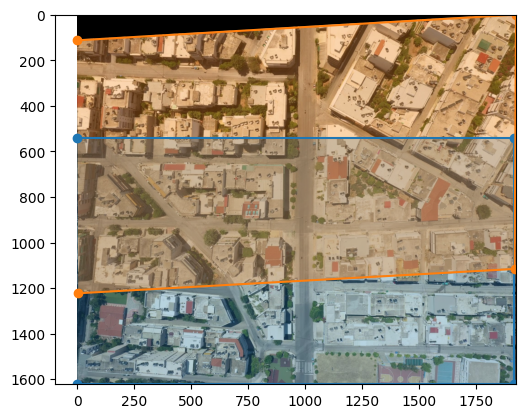

: 

In [4]:
output_path = general_folder_path + 'panorama.jpg'
torch.cuda.empty_cache()

# Utility function to calculate image corners in homogeneous coordinates
def get_homogeneous_corners(width, height):
    return np.array([[0, 0, 1], [width, 0, 1], [width, height, 1], [0, height, 1]]).T

# Warps source image onto a padded canvas to accommodate transformations
def warp_perspective_padded(src, dst, transf):
    src_h, src_w = src.shape[:2]
    corners = get_homogeneous_corners(src_w, src_h)
    
    transformed_corners = transf.dot(corners)
    transformed_corners /= transformed_corners[2, :]  # Normalize coordinates

    minX, minY = np.min(transformed_corners[0]), np.min(transformed_corners[1])
    maxX, maxY = np.max(transformed_corners[0]), np.max(transformed_corners[1])

    dst_h, dst_w = dst.shape[:2]
    pad_h = int(np.round(np.maximum(dst_h, maxY) - np.minimum(0, minY)))
    pad_w = int(np.round(np.maximum(dst_w, maxX) - np.minimum(0, minX)))

    dst_pad = np.zeros((pad_h, pad_w, 3), dtype=np.uint8)

    # Compute translation offsets for bounding box
    anchorX, anchorY = max(0, -int(minX)), max(0, -int(minY))
    transl_transf = np.eye(3)
    transl_transf[:2, 2] = [anchorX, anchorY]

    new_transf = transl_transf.dot(transf)
    new_transf /= new_transf[2, 2]

    dst_pad[anchorY:anchorY + dst_h, anchorX:anchorX + dst_w] = dst
    warped = cv.warpPerspective(src, new_transf, (pad_w, pad_h))

    return dst_pad, warped, anchorX, anchorY

# Rotate image tensor by specified angle
def rotate_image(image, angle):
    return TF.rotate(image, angle)

# Calculate similarity score between two images
def compute_similarity_score(image1, image2, extractor, matcher):
    feats0 = extractor.extract(image1)
    feats1 = extractor.extract(image2)
    feats0, feats1, matches01 = match_pair(extractor, matcher, image1, image2)
    points0 = feats0['keypoints'][matches01['matches'][..., 0]]
    return points0.shape[0]

# Feature extractor and matcher initialization
extractor = DoGHardNet(max_num_keypoints=None).eval().cuda()
matcher = LightGlue(features='doghardnet').eval().cuda()

# Load images
image_path0  = general_folder_path + 'images_updated_1920x1080/4000.jpg'
image_path1 = general_folder_path + 'images_updated_1920x1080/4200.jpg'

image0, image1 = load_image(image_path0), load_image(image_path1)

# Initialize dictionary for image corners
image_corners = {
    image_path0: np.array([[0, 0], [image0.shape[2]-1, 0], [image0.shape[2]-1, image0.shape[1]-1], [0, image0.shape[1]-1]])
}

# Determine best rotation angle
rotation_angles = range(0, 360, 45)
best_score, best_angle = -1, 0

for angle in rotation_angles:
    rotated_image1 = rotate_image(image1, angle)
    score = compute_similarity_score(image0, rotated_image1, extractor, matcher)
    if score > best_score:
        best_score, best_angle = score, angle
        best_rotated_image = rotated_image1

# Prepare images for final stitching
imocv0 = cv.imread(image_path0)
imocv1 = cv.cvtColor(np.array(TF.to_pil_image(best_rotated_image.cpu()).convert("RGB")), cv.COLOR_RGB2BGR)

# Extract keypoints and compute homography matrix
feats0, feats1, matches01 = match_pair(extractor, matcher, image0, best_rotated_image)
points0 = feats0['keypoints'][matches01['matches'][..., 0]].cpu().numpy()
points1 = feats1['keypoints'][matches01['matches'][..., 1]].cpu().numpy()

if points0.shape[0] >= 4:
    M, _ = cv.findHomography(points1, points0, cv.RANSAC, 5.0)
    dst_padded, warped_image1, anchorX, anchorY = warp_perspective_padded(imocv1, imocv0, M)

    # Define source corners as a numpy array and convert to float32
    new_image_corners = np.array([[0, 0], [imocv1.shape[1], 0], [imocv1.shape[1], imocv1.shape[0]], [0, imocv1.shape[0]]], dtype=np.float32)

    # Perform perspective transform with correctly typed data
    transformed_corners = cv.perspectiveTransform(np.array([new_image_corners], dtype=np.float32), M)[0]
    image_corners[image_path1] = transformed_corners + [anchorX, anchorY]

    # Adjust existing image corners in the final panorama
    for img_path, corners in image_corners.items():
        if img_path != image_path1:
            image_corners[img_path] += [anchorX, anchorY]

    # Overlay warped image onto padded destination
    non_zero_mask = (warped_image1 > 0).astype(np.uint8)
    dst_padded[non_zero_mask == 1] = warped_image1[non_zero_mask == 1]

    # Update and display the panorama with corner points
    plt.imshow(cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB))
    plt.axis('on')
    for img_path, corners in image_corners.items():
        x_coords, y_coords = corners[:, 0], corners[:, 1]
        plt.plot(x_coords, y_coords, 'o-', label=os.path.basename(img_path))
        plt.fill(x_coords, y_coords, alpha=0.3)
    plt.show()

    # Save final images
    cv.imwrite(general_folder_path + 'panorama.jpg', dst_padded)
else:
    print("Not enough points to compute homography.")


Stitching Images: 100%|██████████| 19/19 [02:15<00:00,  7.14s/it]


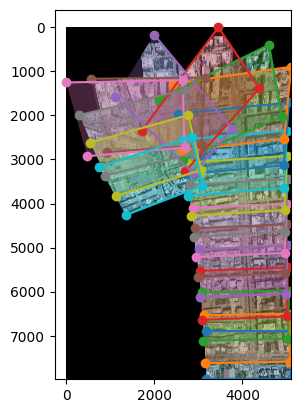

True

In [7]:
import os
import cv2 as cv
import numpy as np
import torch
import torchvision.transforms as T
from matplotlib import pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Set general paths
output_path = general_folder_path + 'panorama.jpg'
torch.cuda.empty_cache()

# Define transformations to handle conversions between NumPy arrays and PyTorch tensors
to_tensor = T.ToTensor()
to_pil = T.ToPILImage()

# Utility function definitions (as provided previously)
images_path = general_folder_path + 'images/'
# Load all images in the folder
image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg')])
image_paths = [os.path.join(images_path, f) for f in image_files]

# Initialize dictionary for image corners and set up the first image as the initial panorama
image_corners = {}

# Load the first image and set as the initial panorama in dst_padded
first_image_path = image_paths[0]
dst_padded = cv.imread(first_image_path)
image_corners[first_image_path] = np.array([[0, 0], [dst_padded.shape[1] - 1, 0],
                                            [dst_padded.shape[1] - 1, dst_padded.shape[0] - 1],
                                            [0, dst_padded.shape[0] - 1]])

# Convert dst_padded to PyTorch tensor with batch dimension for feature extraction
dst_padded_tensor = to_tensor(dst_padded).unsqueeze(0).cuda()  # (1, C, H, W)

# Loop through each subsequent image in the folder with a progress bar
for i in tqdm(range(1, len(image_paths)-18), desc="Stitching Images"):
    current_image_path = image_paths[i]
    current_image = cv.imread(current_image_path)

    # Convert current image to tensor with batch dimension for feature extraction
    current_image_tensor = to_tensor(current_image).unsqueeze(0).cuda()  # (1, C, H, W)

    # Determine the best rotation angle for alignment
    best_score, best_angle = -1, 0
    for angle in range(0, 360, 45):
        rotated_image = rotate_image(current_image_tensor, angle)
        score = compute_similarity_score(dst_padded_tensor, rotated_image, extractor, matcher)
        if score > best_score:
            best_score, best_angle = score, angle
            best_rotated_image = rotated_image

    # Convert best rotated image back to NumPy format for further processing with OpenCV
    imocv_current = cv.cvtColor(np.array(to_pil(best_rotated_image.squeeze(0).cpu())), cv.COLOR_RGB2BGR)
    
    # Extract keypoints and compute homography matrix
    feats0, feats1, matches01 = match_pair(extractor, matcher, dst_padded_tensor, best_rotated_image)
    points0 = feats0['keypoints'][matches01['matches'][..., 0]].cpu().numpy()
    points1 = feats1['keypoints'][matches01['matches'][..., 1]].cpu().numpy()
    
    if points0.shape[0] >= 4:
        # Compute homography and warp the current image
        M, _ = cv.findHomography(points1, points0, cv.RANSAC, 5.0)
        dst_padded, warped_image, anchorX, anchorY = warp_perspective_padded(imocv_current, dst_padded, M)

        # Update corners for the current image
        new_image_corners = np.array([[0, 0], [imocv_current.shape[1], 0],
                                      [imocv_current.shape[1], imocv_current.shape[0]], 
                                      [0, imocv_current.shape[0]]], dtype=np.float32)
        transformed_corners = cv.perspectiveTransform(np.array([new_image_corners], dtype=np.float32), M)[0]
        image_corners[current_image_path] = transformed_corners + [anchorX, anchorY]

        # Adjust all existing image corners
        for img_path, corners in image_corners.items():
            if img_path != current_image_path:
                image_corners[img_path] += [anchorX, anchorY]

        # Overlay warped image onto padded destination
        non_zero_mask = (warped_image > 0).astype(np.uint8)
        dst_padded[non_zero_mask == 1] = warped_image[non_zero_mask == 1]

        # Update dst_padded_tensor to reflect the updated panorama for the next iteration
        dst_padded_tensor = to_tensor(dst_padded).unsqueeze(0).cuda()

    else:
        print(f"Not enough points to compute homography for {current_image_path}.")

# Display final panorama with corners
plt.imshow(cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB))
plt.axis('on')
for img_path, corners in image_corners.items():
    x_coords, y_coords = corners[:, 0], corners[:, 1]
    plt.plot(x_coords, y_coords, 'o-', label=os.path.basename(img_path))
    plt.fill(x_coords, y_coords, alpha=0.3)
plt.show()

# Save the final panorama
cv.imwrite(output_path, dst_padded)


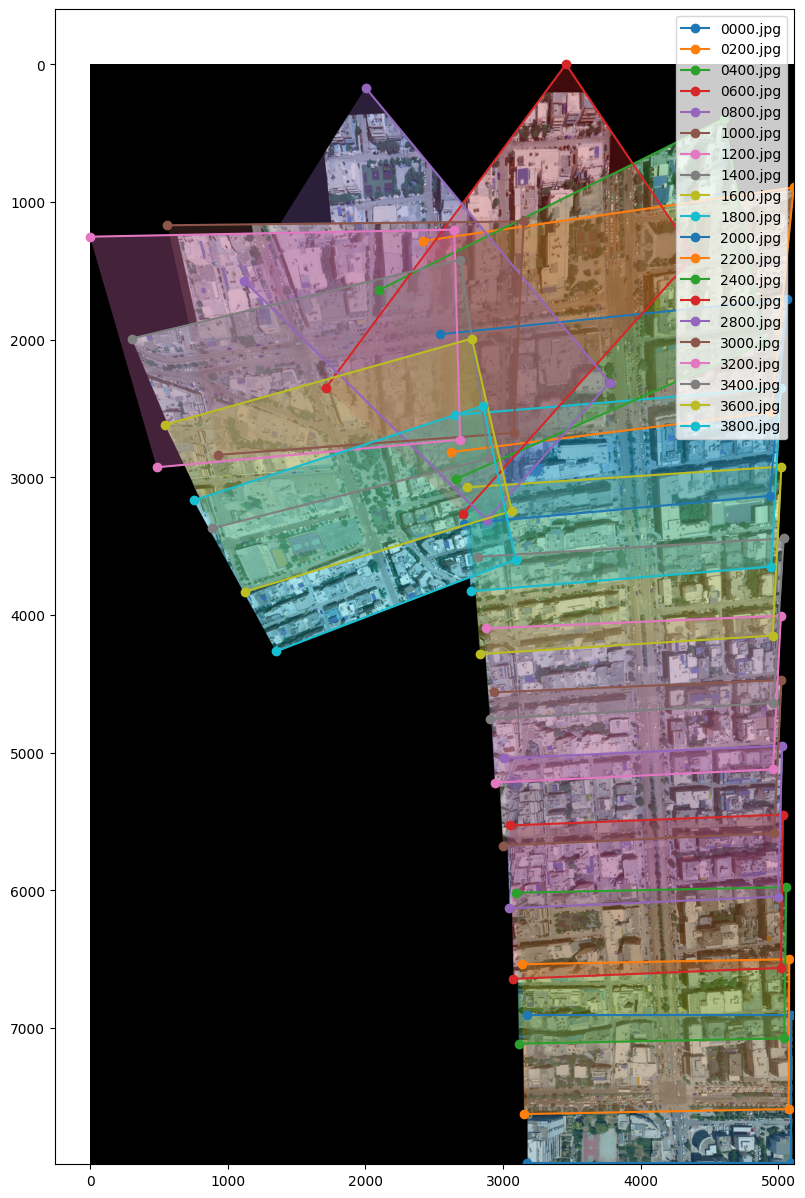

In [8]:
import matplotlib.pyplot as plt
import cv2 as cv

# Set a larger figure size (adjust dimensions as needed)
plt.figure(figsize=(30, 15))  # Width and height in inches

# Display the final panorama
plt.imshow(cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB))
plt.axis('on')

# Plot corners of each stitched image with labels
for img_path, corners in image_corners.items():
    x_coords, y_coords = corners[:, 0], corners[:, 1]
    plt.plot(x_coords, y_coords, 'o-', label=os.path.basename(img_path))
    plt.fill(x_coords, y_coords, alpha=0.3)

# Display legend and show the plot
plt.legend(loc="upper right")  # Optionally add a legend to identify images
plt.show()


In [9]:
import plotly.graph_objects as go
import cv2 as cv
import numpy as np

# Convert the stitched image (dst_padded) to RGB format and get its dimensions
dst_rgb = cv.cvtColor(dst_padded, cv.COLOR_BGR2RGB)
height, width, _ = dst_rgb.shape

# Create a Plotly figure with the image
fig = go.Figure()

# Add the panorama image as a background
fig.add_trace(go.Image(z=dst_rgb))

# Overlay corner points on the image
for img_path, corners in image_corners.items():
    x_coords, y_coords = corners[:, 0], corners[:, 1]
    fig.add_trace(go.Scatter(
        x=x_coords,
        y=y_coords,
        mode='lines+markers',
        fill='toself',
        name=os.path.basename(img_path),
        marker=dict(size=5),
        line=dict(width=2)
    ))

# Update layout to match the image dimensions and remove axes
fig.update_layout(
    width=width,
    height=height,
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    showlegend=True
)

# Invert y-axis to align with the image orientation
fig.update_yaxes(autorange="reversed")

# Display the interactive Plotly figure
fig.show()


In [2]:
import os
import torch
import cv2 as cv
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.cuda.empty_cache()

def clear_cuda_cache():
    """Clears the CUDA cache to free up memory."""
    torch.cuda.empty_cache()

def rotate_image(image: torch.Tensor, angle: float) -> torch.Tensor:
    """Rotate an image tensor by a specified angle."""
    return TF.rotate(image, angle)

def compute_similarity_score(image1, image2, extractor, matcher):
    """Compute similarity score based on keypoint matching between two images."""
    feats0 = extractor.extract(image1)
    feats1 = extractor.extract(image2)
    feats0, feats1, matches01 = match_pair(extractor, matcher, image1, image2)
    matches = matches01['matches']
    points0 = feats0['keypoints'][matches[..., 0]]
    points1 = feats1['keypoints'][matches[..., 1]]
    return points0.shape[0]

def warp_perspective_padded(src, dst, transf):
    """Warp perspective with padding to ensure the entire image fits in the panorama."""
    src_h, src_w = src.shape[:2]
    lin_homg_pts = np.array([[0, src_w, src_w, 0], [0, 0, src_h, src_h], [1, 1, 1, 1]])

    trans_lin_homg_pts = transf.dot(lin_homg_pts)
    trans_lin_homg_pts /= trans_lin_homg_pts[2, :]

    minX = np.min(trans_lin_homg_pts[0, :])
    minY = np.min(trans_lin_homg_pts[1, :])
    maxX = np.max(trans_lin_homg_pts[0, :])
    maxY = np.max(trans_lin_homg_pts[1, :])

    dst_sz = list(dst.shape)
    pad_sz = dst_sz.copy()
    pad_sz[0] = np.round(np.maximum(dst_sz[0], maxY) - np.minimum(0, minY)).astype(int)
    pad_sz[1] = np.round(np.maximum(dst_sz[1], maxX) - np.minimum(0, minX)).astype(int)
    dst_pad = np.zeros(pad_sz, dtype=np.uint8)

    anchorX, anchorY = 0, 0
    transl_transf = np.eye(3, 3)
    if minX < 0:
        anchorX = np.round(-minX).astype(int)
        transl_transf[0, 2] += anchorX
    if minY < 0:
        anchorY = np.round(-minY).astype(int)
        transl_transf[1, 2] += anchorY
    new_transf = transl_transf.dot(transf)
    new_transf /= new_transf[2, 2]

    dst_pad[anchorY:anchorY + dst_sz[0], anchorX:anchorX + dst_sz[1]] = dst
    warped = cv.warpPerspective(src, new_transf, (pad_sz[1], pad_sz[0]))

    return dst_pad, warped, anchorX, anchorY

def find_best_rotation(image1, image2, extractor, matcher, rotation_angles=range(0, 360, 45)):
    """Find the best rotation angle for matching two images."""
    best_score, best_angle, best_rotated_image = -1, 0, image2

    for angle in rotation_angles:
        rotated_image = rotate_image(image2, angle)
        clear_cuda_cache()

        score = compute_similarity_score(image1, rotated_image, extractor, matcher)
        if score > best_score:
            best_score = score
            best_angle = angle
            best_rotated_image = rotated_image
        del rotated_image
        clear_cuda_cache()

    return best_rotated_image

def stitch_images(base_image_path, image_files, extractor, matcher, output_path):
    """Main function to stitch images into a panorama."""
    current_panorama = load_image(base_image_path)
    image_corners = initialize_image_corners(base_image_path, current_panorama)
    
    for image_path in tqdm(image_files[1:], desc="Stitching images"):
        image = load_image(image_path)
        rotated_image = find_best_rotation(current_panorama, image, extractor, matcher)
        
        imocv0 = cv.imread(base_image_path)
        imocv1 = TF.to_pil_image(rotated_image.cpu()).convert("RGB")
        imocv1 = cv.cvtColor(np.array(imocv1), cv.COLOR_RGB2BGR)

        feats0 = extractor.extract(current_panorama)
        feats1 = extractor.extract(rotated_image)
        feats0, feats1, matches01 = match_pair(extractor, matcher, current_panorama, rotated_image)
        points0 = feats0['keypoints'][matches01['matches'][..., 0]].cpu().numpy()
        points1 = feats1['keypoints'][matches01['matches'][..., 1]].cpu().numpy()

        if points0.shape[0] >= 4:
            M, _ = cv.findHomography(points1, points0, cv.RANSAC, 5.0)
            dst_padded, warped_image, anchorX, anchorY = warp_perspective_padded(imocv1, imocv0, M)

            update_image_corners(image_corners, image_path, imocv1, M, anchorX, anchorY)
            combine_non_overlapping_regions(dst_padded, warped_image)

            current_panorama = torch.from_numpy(dst_padded).permute(2, 0, 1).float().cuda() / 255.0
            base_image_path = output_path
            cv.imwrite(output_path, dst_padded)
        else:
            print(f"Not enough matches to compute homography for {os.path.basename(image_path)}")

    display_stitched_panorama(dst_padded, image_corners)

def initialize_image_corners(base_image_path, image):
    """Initialize corner coordinates for the first image in the panorama."""
    return {base_image_path: np.array([[0, 0], 
                                       [image.shape[2]-1, 0], 
                                       [image.shape[2]-1, image.shape[1]-1], 
                                       [0, image.shape[1]-1]])}

def update_image_corners(image_corners, image_path, image, M, anchorX, anchorY):
    """Update corner coordinates for each image in the panorama."""
    h, w = image.shape[:2]
    new_image_corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype='float32')
    transformed_corners = cv.perspectiveTransform(np.array([new_image_corners]), M)[0]
    transformed_corners += np.array([anchorX, anchorY])
    image_corners[image_path] = transformed_corners

    for img_path, corners in image_corners.items():
        if img_path != image_path:
            image_corners[img_path] += np.array([anchorX, anchorY])

def combine_non_overlapping_regions(dst_padded, warped_image):
    """Combine non-overlapping regions between destination and warped images."""
    non_zero_mask = (warped_image > 0).astype(np.uint8)
    dst_padded[non_zero_mask == 1] = warped_image[non_zero_mask == 1]

def display_stitched_panorama(stitched_image, image_corners):
    """Display the stitched panorama and corner points for each image."""
    plt.figure(figsize=(10, 10))
    plt.imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB))
    plt.axis('off')

    for img_path, corners in image_corners.items():
        x_coords, y_coords = corners[:, 0], corners[:, 1]
        plt.plot(x_coords, y_coords, 'o-', label=os.path.basename(img_path))
        plt.fill(x_coords, y_coords, alpha=0.3)
    
    plt.legend(loc="upper right")
    plt.title("Corners of Each Image in Final Stitched Panorama")
    plt.show()

# Usage Example
extractor = DoGHardNet(max_num_keypoints=None).eval().cuda()
matcher = LightGlue(features='doghardnet').eval().cuda()
image_folder_path = os.path.join(general_folder_path, 'images')
image_files = sorted([os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith('.jpg')])
base_image_path = image_files[0]
output_path = os.path.join(general_folder_path, 'stitched_panorama.jpg')

stitch_images(base_image_path, image_files, extractor, matcher, output_path)


Stitching images:  14%|█▎        | 5/37 [00:57<06:07, 11.48s/it]


MemoryError: Unable to allocate 42.3 GiB for an array with shape (19537, 775583, 3) and data type uint8